In [1]:
# Import Libraries
import os
import rasterio
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

In [2]:
# Cek Direktori
print("Direktori kerja saat ini:", os.getcwd())

Direktori kerja saat ini: d:\Geodatabase\Linear_Model_Presipitasi


In [3]:
# Fungsi untuk membaca data raster
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Membaca band pertama
        data = data.astype(float)
        if src.nodata is not None:
            data[data == src.nodata] = np.nan
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    return data, extent

In [4]:
# File path untuk input data raster
precipitation_file = r"D:\Geodatabase\Linear_Model_Presipitasi\01_Raw_Data\01_Presipitasi.tif"
temperature_file = r"D:\Geodatabase\Linear_Model_Presipitasi\01_Raw_Data\02_Suhu_Rata_Rata.tif"
solar_radiation_file = r"D:\Geodatabase\Linear_Model_Presipitasi\01_Raw_Data\03_Radiasi_Matahari.tif"
water_vapor_pressure_file = r"D:\Geodatabase\Linear_Model_Presipitasi\01_Raw_Data\04_Tekanan_Uap_Air.tif"
wind_speed_file = r"D:\Geodatabase\Linear_Model_Presipitasi\01_Raw_Data\05_Kecepatan_Angin.tif"

In [5]:
# File path untuk output raster predicted
predicted_raster_file = r"D:\Geodatabase\Linear_Model_Presipitasi\02_Hasil_Linear_Model\Presipitasi_Prediksi.tif"

In [6]:
# Fungsi untuk membaca data raster sebagai array
def read_raster_as_array(filepath):
    with rasterio.open(filepath) as src:
        data = src.read(1).astype(float)  # Membaca band pertama
        if src.nodata is not None:
            data[data == src.nodata] = np.nan  # Mengatur nilai nodata ke NaN
    return data.flatten()

In [7]:
# Membaca data raster sebagai array
precipitation = read_raster_as_array(precipitation_file)
temperature = read_raster_as_array(temperature_file)
solar_radiation = read_raster_as_array(solar_radiation_file)
water_vapor_pressure = read_raster_as_array(water_vapor_pressure_file)
wind_speed = read_raster_as_array(wind_speed_file)

In [8]:
# Menggabungkan data independen menjadi satu matriks
X = np.column_stack((temperature, solar_radiation, water_vapor_pressure, wind_speed))

In [9]:
# Menghapus data dengan nilai NaN
mask = ~np.isnan(precipitation) & ~np.isnan(X).any(axis=1)
Y = precipitation[mask]
X = X[mask]

In [10]:
# Menambahkan intercept ke matriks X untuk model linear
X = sm.add_constant(X)

In [11]:
# Membuat model linear
model = sm.OLS(Y, X)
results = model.fit()

In [12]:
# Menampilkan ringkasan hasil model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     427.4
Date:                Thu, 12 Dec 2024   Prob (F-statistic):           1.54e-87
Time:                        10:31:47   Log-Likelihood:                -867.51
No. Observations:                 175   AIC:                             1745.
Df Residuals:                     170   BIC:                             1761.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.083e+04    390.100     27.750      0.0

In [13]:
# Membuat prediksi menggunakan model
predictions = results.predict(X)

In [14]:
def save_array_to_raster(reference_file, output_file, predictions, mask):
    with rasterio.open(reference_file) as src:
        meta = src.meta
    
    # Reshape mask agar sesuai dengan dimensi raster
    height, width = meta['height'], meta['width']
    mask_reshaped = mask.reshape(height, width)

    # Buat array output yang diisi dengan NaN
    output_data = np.full((height, width), np.nan, dtype=np.float32)
    
    # Tetapkan prediksi ke posisi yang valid dalam array output
    output_data[mask_reshaped] = predictions
    
    # Perbarui metadata dan tulis raster baru
    meta.update(dtype=rasterio.float32, count=1, nodata=np.nan)
    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(output_data, 1)
    
    # Pesan konfirmasi
    print(f"File berhasil disimpan: {output_file}")

# Simpan prediksi raster
save_array_to_raster(precipitation_file, predicted_raster_file, predictions, mask)


File berhasil disimpan: D:\Geodatabase\Linear_Model_Presipitasi\02_Hasil_Linear_Model\Presipitasi_Prediksi.tif


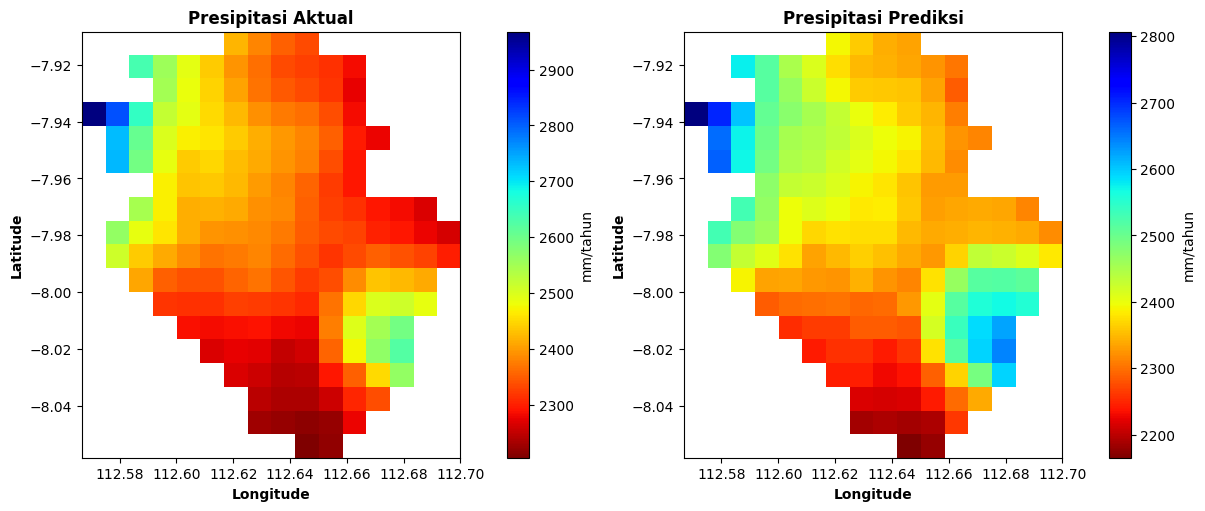

Facet grid berhasil disimpan sebagai file: D:\Geodatabase\Linear_Model_Presipitasi\03_Evaluasi_Model\facet_grid_precipitasi.png


In [15]:
# Membuat visualisasi facet grid
output_file = r"D:\Geodatabase\Linear_Model_Presipitasi\03_Evaluasi_Model\facet_grid_precipitasi.png"
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Membaca dan menampilkan data raster
files = [precipitation_file, predicted_raster_file]
titles = ["Presipitasi Aktual", "Presipitasi Prediksi"]
for ax, file, title in zip(axes, files, titles):
    data, extent = read_raster(file)
    im = ax.imshow(data, extent=extent, cmap="jet_r", interpolation="none")
    ax.set_title(title, fontweight = "bold")
    ax.set_xlabel("Longitude", fontweight = "bold")
    ax.set_ylabel("Latitude", fontweight = "bold")
    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.set_label("mm/tahun")

plt.savefig(output_file, dpi=300, bbox_inches="tight")
plt.show()
print("Facet grid berhasil disimpan sebagai file:", output_file)

In [16]:
# Menghitung hubungan antara variabel independen dan dependen
correlation_temperature = np.corrcoef(temperature[mask], Y)[0, 1]
correlation_solar_radiation = np.corrcoef(solar_radiation[mask], Y)[0, 1]
correlation_water_vapor_pressure = np.corrcoef(water_vapor_pressure[mask], Y)[0, 1]
correlation_wind_speed = np.corrcoef(wind_speed[mask], Y)[0, 1]

print(f"Korelasi antara suhu rata-rata dengan presipitasi: {correlation_temperature:.2f}")
print(f"Korelasi antara radiasi matahari dengan presipitasi: {correlation_solar_radiation:.2f}")
print(f"Korelasi antara tekanan uap air dengan presipitasi: {correlation_water_vapor_pressure:.2f}")
print(f"Korelasi antara kecepatan angin dengan presipitasi: {correlation_wind_speed:.2f}")

Korelasi antara suhu rata-rata dengan presipitasi: -0.65
Korelasi antara radiasi matahari dengan presipitasi: -0.33
Korelasi antara tekanan uap air dengan presipitasi: -0.93
Korelasi antara kecepatan angin dengan presipitasi: 0.04


In [17]:
# Evaluasi model
mae = mean_absolute_error(Y, predictions)
mse = mean_squared_error(Y, predictions)
rmse = root_mean_squared_error(Y, predictions)
r2 = r2_score(Y, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 24.627921393263126
MSE: 1183.905818881937
RMSE: 34.40793249938068
R^2: 0.909552447211399


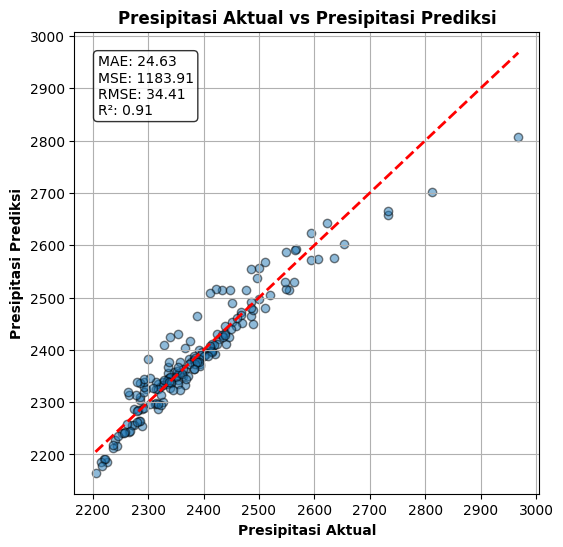

Scatter plot berhasil disimpan sebagai file : D:\Geodatabase\Linear_Model_Presipitasi\03_Evaluasi_Model\scatterplot_actual_vs_predicted.png


In [18]:
# Scatter plot dengan matrik evaluasi
scatter_output_file = r"D:\Geodatabase\Linear_Model_Presipitasi\03_Evaluasi_Model\scatterplot_actual_vs_predicted.png"

plt.figure(figsize=(6, 6))
plt.scatter(Y, predictions, alpha=0.5, edgecolor='k')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--', lw=2)
plt.xlabel('Presipitasi Aktual', fontweight = "bold")
plt.ylabel('Presipitasi Prediksi', fontweight = "bold")
plt.title('Presipitasi Aktual vs Presipitasi Prediksi', fontweight = "bold")
plt.text(0.05, 0.95, f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}",
        transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.grid(True)
plt.savefig(scatter_output_file, dpi=300, bbox_inches="tight")
plt.show()
print("Scatter plot berhasil disimpan sebagai file :", scatter_output_file)